# LightGBM

# 1.导入相关库

In [1]:
import numpy as np
import pandas as pd

#preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

#visualizations
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#algorithms
from lightgbm import LGBMClassifier

#score metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

# 2.读取数据

In [2]:
path = 'C:/Users/82115/Desktop/Buyer-Analysis/data/'
train_df = pd.read_csv(path+'train.csv')
test_df = pd.read_csv(path+'test.csv')
submission = pd.read_csv(path+'submission.csv')
print('Train Shape:{}'.format(train_df.shape))
train_df.head(5)

Train Shape:(8631, 18)


,访客类型,月份,产品相关页面访问持续时间,信息相关页面,用户相关页面,信息相关页面访问持续时间,退出率,跳出率,产品相关页面,网页价值,操作系统,周末,浏览器,用户页面访问持续时间,区域,流量类型,节假日,是否购买
0,Returning_Visitor,Dec,556.916667,0,0,0.000000,0.022436,0.010256,26,0.0,4,False,2,0.00,1,8,0.0,0
1,Returning_Visitor,Dec,2348.812500,5,0,39.833333,0.055167,0.020000,34,0.0,2,False,2,0.00,3,1,0.0,0
2,New_Visitor,June,1570.133333,6,0,89.800000,0.005357,0.000000,26,0.0,2,True,2,0.00,8,4,0.0,0
3,Returning_Visitor,Dec,821.682540,4,2,159.000000,0.019343,0.000617,33,0.0,2,False,2,27.75,1,2,0.0,1
4,Returning_Visitor,Jul,584.377778,5,2,38.577778,0.064352,0.000000,7,0.0,1,True,1,9.00,1,2,0.0,1


# 3.数据分析EDA

## 3.1 各列与是否购买的关系

### 3.1.1 访客类型与是否购买的关系

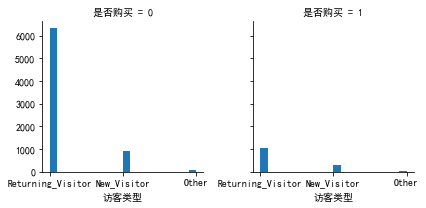

In [3]:
g = sns.FacetGrid(train_df, col='是否购买')
g.map(plt.hist, '访客类型', bins=20)

### 3.1.2 月份与是否购买的关系


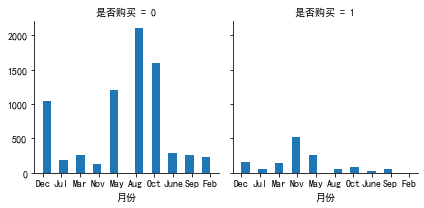

In [4]:
g = sns.FacetGrid(train_df, col='是否购买')
g.map(plt.hist, '月份', bins=20)

### 3.1.3 操作系统与是否购买的关系

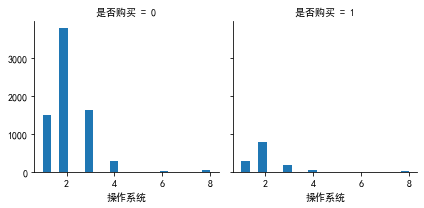

In [5]:
g = sns.FacetGrid(train_df, col='是否购买')
g.map(plt.hist, '操作系统', bins=20)

## 3.2 删除无关列

In [6]:
train_df.drop(['操作系统'], axis=1, inplace=True)

train_df.head()

,访客类型,月份,产品相关页面访问持续时间,信息相关页面,用户相关页面,信息相关页面访问持续时间,退出率,跳出率,产品相关页面,网页价值,周末,浏览器,用户页面访问持续时间,区域,流量类型,节假日,是否购买
0,Returning_Visitor,Dec,556.916667,0,0,0.000000,0.022436,0.010256,26,0.0,False,2,0.00,1,8,0.0,0
1,Returning_Visitor,Dec,2348.812500,5,0,39.833333,0.055167,0.020000,34,0.0,False,2,0.00,3,1,0.0,0
2,New_Visitor,June,1570.133333,6,0,89.800000,0.005357,0.000000,26,0.0,True,2,0.00,8,4,0.0,0
3,Returning_Visitor,Dec,821.682540,4,2,159.000000,0.019343,0.000617,33,0.0,False,2,27.75,1,2,0.0,1
4,Returning_Visitor,Jul,584.377778,5,2,38.577778,0.064352,0.000000,7,0.0,True,1,9.00,1,2,0.0,1


## 3.3 查询数据缺失值

In [7]:
train_missingValues = train_df.isnull().sum()
train_missingValues

test_missingValues = test_df.isnull().sum()
test_missingValues

访客类型               0
月份                 0
产品相关页面访问持续时间       0
信息相关页面             0
用户相关页面             0
信息相关页面访问持续时间       0
退出率                0
跳出率                0
产品相关页面             0
网页价值               0
操作系统               0
周末                 0
浏览器                0
用户页面访问持续时间         0
区域                 0
流量类型               0
节假日                0
是否购买            3699
dtype: int64

## 3.4 根据训练集的列可以得到大致如下三种特征：
- 数字列 产品相关页面访问持续时间、产品相关页面访问持续时间、信息相关页面访问持续时间、退出率、
跳出率、网页价值、用户页面访问持续时间、节假日
- 二值列 周末
- 字符列 访客类型、月份

In [8]:
train_df = pd.get_dummies(train_df)

train_df.head(5)

test_df = pd.get_dummies(test_df)

test_df.head(5)

,产品相关页面访问持续时间,信息相关页面,用户相关页面,信息相关页面访问持续时间,退出率,跳出率,产品相关页面,网页价值,操作系统,周末,浏览器,用户页面访问持续时间,区域,流量类型,节假日,是否购买,访客类型_New_Visitor,访客类型_Other,访客类型_Returning_Visitor,月份_Aug,月份_Dec,月份_Feb,月份_Jul,月份_June,月份_Mar,月份_May,月份_Nov,月份_Oct,月份_Sep
0,5526.080123,6,2,130.500000,0.010700,0.0,78,0.838988,2,False,2,439.2,9,1,0.0,NaN,0,0,1,0,0,0,0,0,0,0,1,0,0
1,1518.097619,2,2,30.500000,0.031765,0.0,15,31.757647,2,False,2,18.0,8,2,0.0,NaN,0,0,1,0,0,0,0,0,0,1,0,0,0
2,337.853333,11,0,280.336667,0.016296,0.0,20,0.000000,2,False,2,0.0,2,5,0.0,NaN,1,0,0,0,0,0,0,0,0,0,0,0,1
3,0.000000,0,0,0.000000,0.200000,0.2,2,0.000000,1,False,1,0.0,1,3,0.6,NaN,0,0,1,0,0,0,0,0,0,1,0,0,0
4,155.000000,4,0,111.000000,0.009091,0.0,9,0.000000,1,False,1,0.0,4,2,0.0,NaN,0,0,1,0,1,0,0,0,0,0,0,0,0


##  3.5 数据处理

In [9]:
num_columns = ['产品相关页面访问持续时间', '产品相关页面访问持续时间', '信息相关页面访问持续时间', '退出率', '跳出率',
               '网页价值', '用户页面访问持续时间', '节假日']

# zero_to_one_columns = ['']
#
str_columns = ['周末']

for i in tqdm(str_columns):
    lbl = LabelEncoder()
    train_df[i] = lbl.fit_transform(train_df[i].astype(str))
    test_df[i] = lbl.fit_transform(test_df[i].astype(str))



train_df[num_columns] = MinMaxScaler().fit_transform(train_df[num_columns])
test_df[num_columns] = MinMaxScaler().fit_transform(test_df[num_columns])

train_df.head(5)

test_df.head(10)

100%|██████████| 1/1 [00:00<00:00, 41.69it/s]


,产品相关页面访问持续时间,信息相关页面,用户相关页面,信息相关页面访问持续时间,退出率,跳出率,产品相关页面,网页价值,操作系统,周末,浏览器,用户页面访问持续时间,区域,流量类型,节假日,是否购买,访客类型_New_Visitor,访客类型_Other,访客类型_Returning_Visitor,月份_Aug,月份_Dec,月份_Feb,月份_Jul,月份_June,月份_Mar,月份_May,月份_Nov,月份_Oct,月份_Sep
0,0.128004,6,2,0.047969,0.053498,0.000000,78,0.002319,2,0,2,0.194602,9,1,0.0,NaN,0,0,1,0,0,0,0,0,0,0,1,0,0
1,0.035165,2,2,0.011211,0.158824,0.000000,15,0.087786,2,0,2,0.007975,8,2,0.0,NaN,0,0,1,0,0,0,0,0,0,1,0,0,0
2,0.007826,11,0,0.103046,0.081481,0.000000,20,0.000000,2,0,2,0.000000,2,5,0.0,NaN,1,0,0,0,0,0,0,0,0,0,0,0,1
3,0.000000,0,0,0.000000,1.000000,1.000000,2,0.000000,1,0,1,0.000000,1,3,0.6,NaN,0,0,1,0,0,0,0,0,0,1,0,0,0
4,0.003590,4,0,0.040801,0.045455,0.000000,9,0.000000,1,0,1,0.000000,4,2,0.0,NaN,0,0,1,0,1,0,0,0,0,0,0,0,0
5,0.019361,0,0,0.000000,0.333333,0.166667,6,0.000000,1,0,1,0.000000,1,1,0.0,NaN,0,0,1,0,0,0,0,0,1,0,0,0,0
6,0.054332,2,3,0.025196,0.064208,0.013746,91,0.141729,2,0,5,0.026585,7,2,0.0,NaN,0,0,1,0,1,0,0,0,0,0,0,0,0
7,0.045751,12,4,0.074722,0.075931,0.018182,47,0.000000,4,0,2,0.107093,4,2,0.0,NaN,0,0,1,0,0,0,0,0,0,0,1,0,0
8,0.020695,5,3,0.048226,0.103261,0.086957,21,0.019603,3,1,2,0.011963,3,4,0.0,NaN,0,0,1,0,0,0,0,0,0,1,0,0,0
9,0.091743,4,0,0.044293,0.068315,0.014706,66,0.000000,2,0,4,0.000000,1,1,0.0,NaN,0,0,1,0,0,0,0,0,1,0,0,0,0


# 4.模型

## 4.1 准备数据集

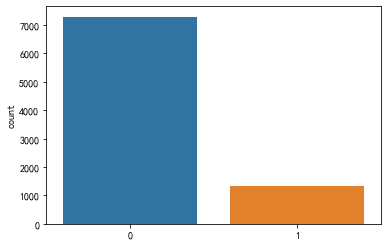

Before OverSampling, counts of label '1': 1336
Before OverSampling, counts of label '0': 7295 



In [10]:
all_columns = [i for i in train_df.columns if i not in ['是否购买']]

train_x, train_y = train_df[all_columns].values, train_df['是否购买'].values
test_x = test_df[all_columns].values
submission['是否购买'] = 0
# 绘制计数直方图
sns.countplot(train_y)
plt.show()

print("Before OverSampling, counts of label '1': {}".format(sum(train_y==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(train_y==0)))

## 4.2 训练模型

In [11]:
kfold = StratifiedKFold(n_splits=5, shuffle=False)


model = LGBMClassifier(
    boosting_type="gbdt", num_leaves=120, reg_alpha=0, reg_lambda=0.,
    max_depth=-1, n_estimators=200, objective='binary',
    subsample=0.9, colsample_bytree=0.5, subsample_freq=1,
    learning_rate=0.035, random_state=2018
    )

result = []

for train, valid in kfold.split(train_x, train_y):
    X_train, Y_train = train_x[train], train_y[train]
    X_valid, Y_valid = train_x[valid], train_y[valid]
    model.fit(X_train,Y_train, eval_set=(X_valid, Y_valid))
    Y_valid_pred_prob = model.predict_proba(X_valid)
    result.append(roc_auc_score(Y_valid, Y_valid_pred_prob[:, 1]))
    submission['是否购买'] += model.predict_proba(test_x)[:, 1] / 5
print(result)

[1]	valid_0's binary_logloss: 0.416097
[2]	valid_0's binary_logloss: 0.412899
[3]	valid_0's binary_logloss: 0.410282
[4]	valid_0's binary_logloss: 0.397542
[5]	valid_0's binary_logloss: 0.394561
[6]	valid_0's binary_logloss: 0.383997
[7]	valid_0's binary_logloss: 0.373884
[8]	valid_0's binary_logloss: 0.365528
[9]	valid_0's binary_logloss: 0.363522
[10]	valid_0's binary_logloss: 0.356132
[11]	valid_0's binary_logloss: 0.353989
[12]	valid_0's binary_logloss: 0.352061
[13]	valid_0's binary_logloss: 0.350612
[14]	valid_0's binary_logloss: 0.349361
[15]	valid_0's binary_logloss: 0.347815
[16]	valid_0's binary_logloss: 0.346091
[17]	valid_0's binary_logloss: 0.344987
[18]	valid_0's binary_logloss: 0.338773
[19]	valid_0's binary_logloss: 0.333202
[20]	valid_0's binary_logloss: 0.331756
[21]	valid_0's binary_logloss: 0.326669
[22]	valid_0's binary_logloss: 0.325496
[23]	valid_0's binary_logloss: 0.32451
[24]	valid_0's binary_logloss: 0.323545
[25]	valid_0's binary_logloss: 0.319134
[26]	valid

写到输出文件

In [12]:
submission.to_csv('submission_LightGBM.csv', index=False)
